# 💼 경제활동에 따른 금연 성공 상관관계 분석

**담당자:** 오흥재  
**목표:** 경제활동 상태가 금연 성공(churn)에 미치는 영향 분석

---

## 📋 분석 계획

### 1️⃣ **핵심 변수**
- `soa_01z1`: 경제활동 여부 (예/아니오)
- `soa_06z2`: 직업분류 (관리자, 전문가, 사무직...)
- `soa_07z1`: 종사상지위 (고용주, 임금근로자, 무급가족종사자)
- `churn`: 금연 성공 여부 (1=성공, 0=실패)

### 2️⃣ **분석 단계**
1. 경제활동 변수 기초 분석
2. 경제활동 여부 × 금연 성공률
3. 직업분류 × 금연 성공률
4. 종사상지위 × 금연 성공률
5. 통계적 검정 및 인사이트

In [3]:
# 환경 설정
import sys
import os
project_root = os.path.abspath('../../..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.font_manager as fm

# Variable Decoder 최신 버전 (fallback 지원)
from notebooks.vfxpedia.utils.variable_decoder import (
    VariableDecoder,
    get_korean_label,
    get_korean_labels,
    create_korean_labels_dict
)

# 팀 시각화 스타일
try:
    font_path = "C:/Windows/Fonts/HMFMMUEX.TTC"
    if os.path.exists(font_path):
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
    else:
        plt.rcParams['font.family'] = 'Malgun Gothic'
except:
    plt.rcParams['font.family'] = 'Malgun Gothic'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

# 팀 컬러
TEAM_COLORS = {
    'primary': '#1f77b4',
    'success': '#ff7f0e',
    'danger': '#1f77b4',
    'palette': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
}

print('✅ 환경 설정 완료!')

✅ 환경 설정 완료!


## 📂 Step 1: 데이터 로드 및 변수 디코딩

In [11]:
# 데이터 로드
df = pd.read_csv('../output/analy_data_cleaned.csv')
decoder = VariableDecoder()

df_work = df.copy()

# 경제활동 관련 변수 디코딩
df_work['sob_01z1_decoded'] = df_work['sob_01z1'].apply(lambda x: decoder.decode_value('sob_01z1', x))
df_work['soa_06z2_decoded'] = df_work['soa_06z2'].apply(lambda x: decoder.decode_value('soa_06z2', x))
df_work['soa_07z1_decoded'] = df_work['soa_07z1'].apply(lambda x: decoder.decode_value('soa_07z1', x))

print(f'전체 데이터: {df_work.shape}')
print('\n✅ 디코딩 완료!')
print(df_work[['sob_01z1_decoded', 'soa_06z2_decoded', 'soa_07z1_decoded', 'churn']].head(10))

✅ variable.csv 로드 완료: 709 개 매핑
✅ variable_full.csv 로드 완료: 681 개 매핑 (fallback)
전체 데이터: (89757, 213)

✅ 디코딩 완료!
  sob_01z1_decoded soa_06z2_decoded soa_07z1_decoded  churn
0            4년제대학            사무종사자            임금근로자      1
1             고등학교           서비스종사자            임금근로자      0
2          2년3년제대학           서비스종사자            임금근로자      1
3            4년제대학            사무종사자            임금근로자      0
4             초등학교              비해당              비해당      0
5             초등학교              비해당              비해당      1
6            4년제대학        전문가및관련종사자            임금근로자      1
7            4년제대학        전문가및관련종사자            임금근로자      0
8            대학원이상            사무종사자            임금근로자      1
9             고등학교              비해당              비해당      1


## 🔍 Step 2: 경제활동 변수 기초 분석

=== 경제활동 여부 분포 ===
예      64784
아니오    24973
Name: count, dtype: int64


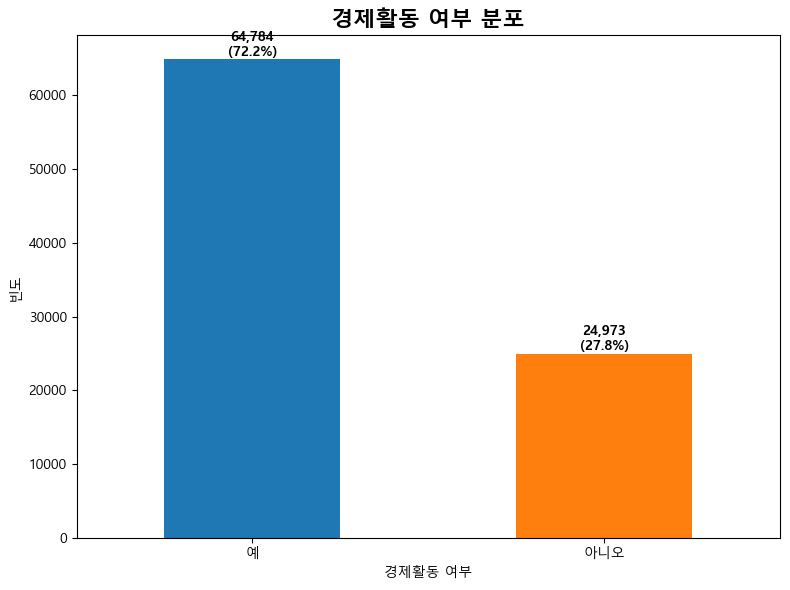

In [17]:
# 경제활동 여부 분포
print('=== 경제활동 여부 분포 ===')
econ_status = decoder.create_value_counts_decoded(df_work, 'soa_01z1')
print(econ_status)

fig, ax = plt.subplots(figsize=(8, 6))
econ_status.plot(kind='bar', ax=ax, color=TEAM_COLORS['palette'])
ax.set_title('경제활동 여부 분포', fontsize=16, fontweight='bold')
ax.set_xlabel('경제활동 여부')
ax.set_ylabel('빈도')
plt.xticks(rotation=0)
for i, v in enumerate(econ_status):
    ax.text(i, v + 500, f'{v:,}\n({v/econ_status.sum()*100:.1f}%)', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()


=== 직업분류 분포 (경제활동자) ===
단순노무종사자         9667
농림어업종사자         9647
장치기계조작및조립종사자    8696
사무종사자           8464
전문가및관련종사자       7771
기능원및관련기능종사자     7452
서비스종사자          5800
판매종사자           4603
관리자             2280
군인               404
Name: count, dtype: int64


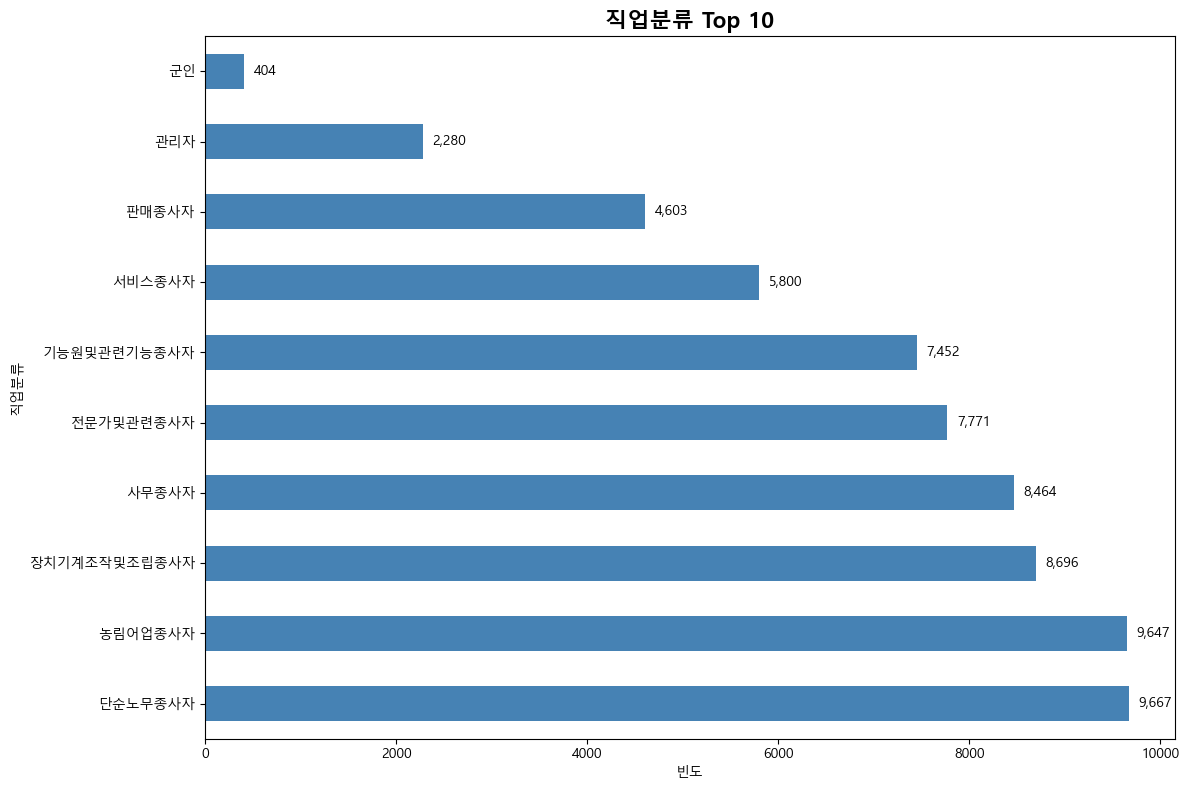

In [20]:
# 직업분류 분포 (경제활동자만)
print('\n=== 직업분류 분포 (경제활동자) ===')
job_dist = decoder.create_value_counts_decoded(
    df_work[df_work['soa_01z1'] == 1.0], 
    'soa_06z2'
)
print(job_dist.head(10))

fig, ax = plt.subplots(figsize=(12, 8))
job_dist.head(10).plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('직업분류 Top 10', fontsize=16, fontweight='bold')
ax.set_xlabel('빈도')
ax.set_ylabel('직업분류')
for i, v in enumerate(job_dist.head(10)):
    ax.text(v + 100, i, f'{v:,}', va='center')
plt.tight_layout()
plt.show()

## 📊 Step 3: 경제활동 × 금연 성공률

=== 경제활동 여부별 금연 성공률 ===
                  count    sum  success_rate(%)
soa_01z1_decoded                               
아니오               24973  16172        64.757939
예                 64784  33048        51.012596


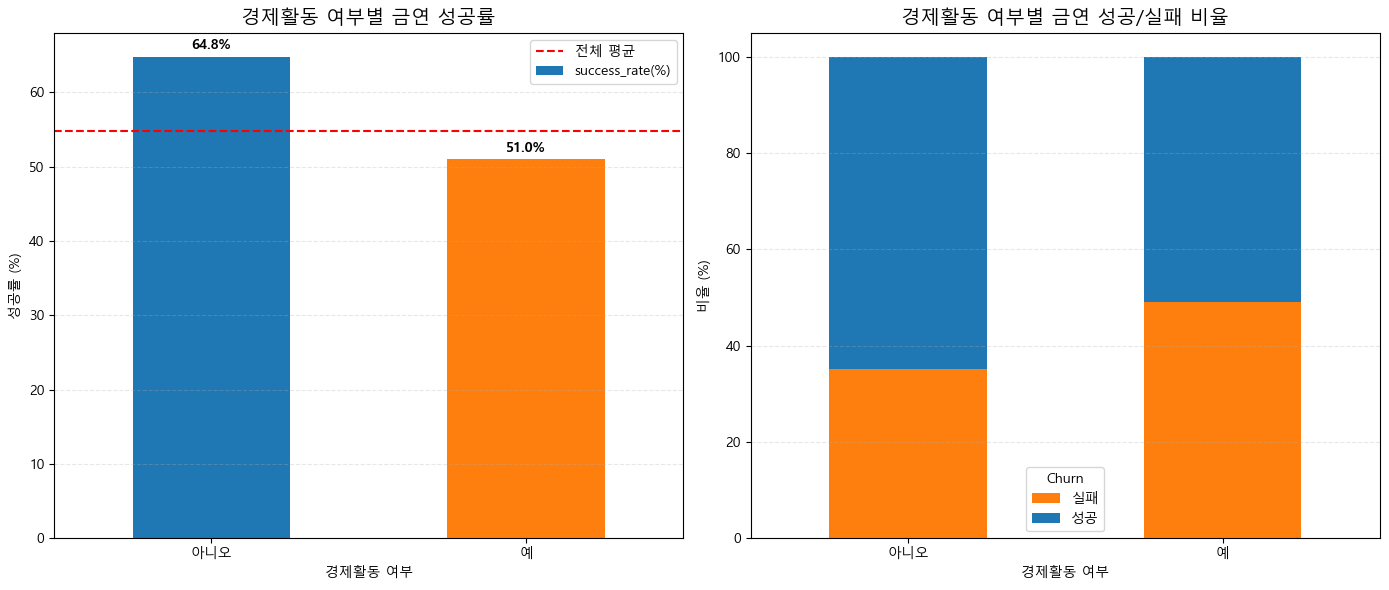

In [23]:
# 'soa_01z1_decoded' 컬럼 생성 (최신 Variable Decoder 방식)
if 'soa_01z1_decoded' not in df_work.columns:
    df_work['soa_01z1_decoded'] = df_work['soa_01z1'].apply(
        lambda x: decoder.decode_value('soa_01z1', x)
    )

# 경제활동 여부별 금연 성공률
success_by_econ = df_work.groupby('soa_01z1_decoded')['churn'].agg(['sum', 'count', 'mean'])
success_by_econ['success_rate(%)'] = success_by_econ['mean'] * 100

print('=== 경제활동 여부별 금연 성공률 ===')
print(success_by_econ[['count', 'sum', 'success_rate(%)']])

# 시각화 (팀 컬러 적용)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 성공률 막대그래프
success_by_econ['success_rate(%)'].plot(kind='bar', ax=axes[0], 
                                         color=[TEAM_COLORS['primary'], TEAM_COLORS['success']])
axes[0].set_title('경제활동 여부별 금연 성공률', fontsize=14)
axes[0].set_ylabel('성공률 (%)')
axes[0].set_xlabel('경제활동 여부')
axes[0].axhline(df_work['churn'].mean() * 100, color='red', linestyle='--', label='전체 평균')
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)

for i, v in enumerate(success_by_econ['success_rate(%)']):
    axes[0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# 스택 바 차트
churn_cross = pd.crosstab(df_work['soa_01z1_decoded'], df_work['churn'], normalize='index') * 100
churn_cross.plot(kind='bar', stacked=True, ax=axes[1], 
                 color=[TEAM_COLORS['success'], TEAM_COLORS['danger']])
axes[1].set_title('경제활동 여부별 금연 성공/실패 비율', fontsize=14)
axes[1].set_ylabel('비율 (%)')
axes[1].set_xlabel('경제활동 여부')
axes[1].legend(['실패', '성공'], title='Churn')
axes[1].grid(axis='y', linestyle='--', alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## 💼 Step 4: 직업분류 × 금연 성공률

=== 직업분류별 금연 성공률 (표본 100명 이상) ===
                  count  success_rate(%)
soa_06z2_decoded                        
농림어업종사자            9647        62.309526
전문가및관련종사자          7771        55.552696
관리자                2280        52.894737
단순노무종사자            9667        51.980966
사무종사자              8464        51.051512
장치기계조작및조립종사자       8696        47.309108
판매종사자              4603        46.339344
서비스종사자             5800        44.534483
기능원및관련기능종사자        7452        42.646269
군인                  404        39.603960


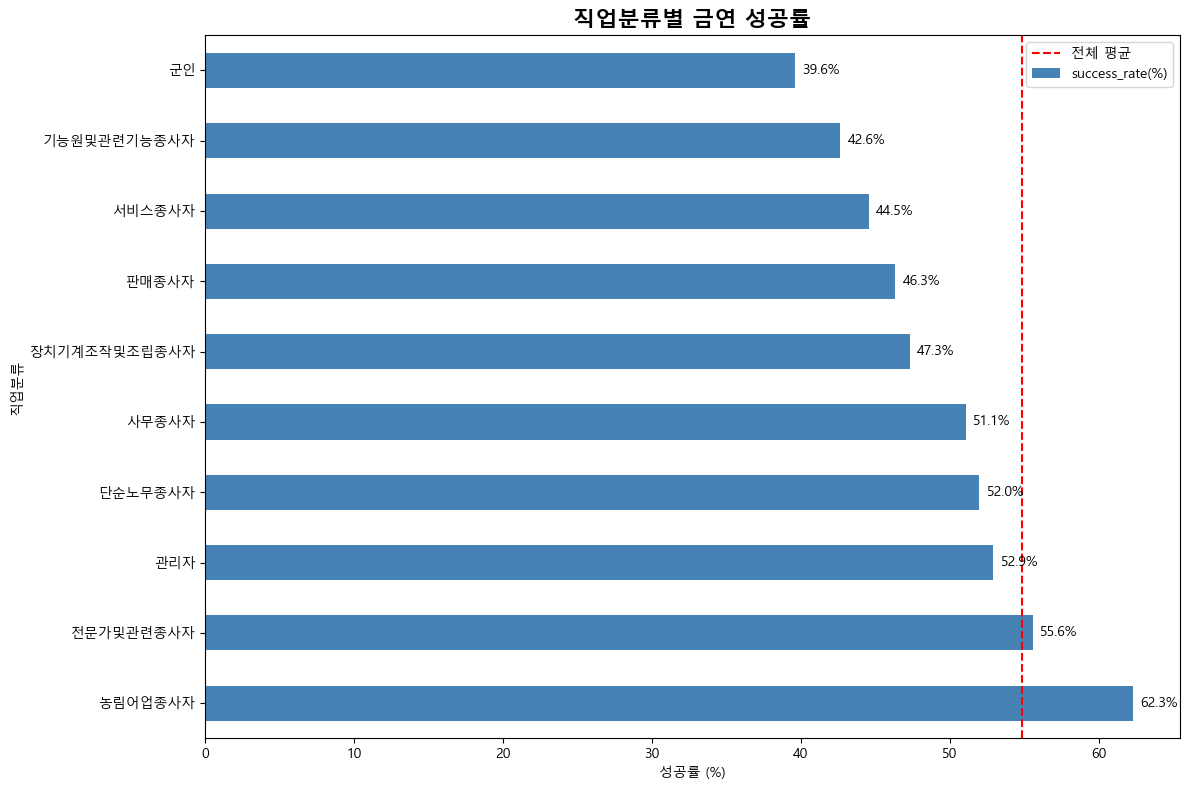

In [25]:
# 직업분류별 금연 성공률 (경제활동자만, 최소 100명 이상)
job_success = df_work[df_work['soa_01z1'] == 1.0].groupby('soa_06z2_decoded')['churn'].agg(
    ['sum', 'count', 'mean']
)
job_success = job_success[job_success['count'] >= 100]  # 최소 표본 크기
job_success['success_rate(%)'] = job_success['mean'] * 100
job_success = job_success.sort_values('success_rate(%)', ascending=False)

print('=== 직업분류별 금연 성공률 (표본 100명 이상) ===')
print(job_success[['count', 'success_rate(%)']])

# 시각화
fig, ax = plt.subplots(figsize=(12, 8))
job_success['success_rate(%)'].plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('직업분류별 금연 성공률', fontsize=16, fontweight='bold')
ax.set_xlabel('성공률 (%)')
ax.set_ylabel('직업분류')
ax.axvline(df_work['churn'].mean() * 100, color='red', linestyle='--', label='전체 평균')
ax.legend()

for i, v in enumerate(job_success['success_rate(%)']):
    ax.text(v + 0.5, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.show()

## 👔 Step 5: 종사상지위 × 금연 성공률

=== 종사상지위별 금연 성공률 ===
                  count  success_rate(%)
soa_07z1_decoded                        
고용주및자영업자          23141        55.676073
무급가족종사자            1112        55.575540
임금근로자             40531        48.224816


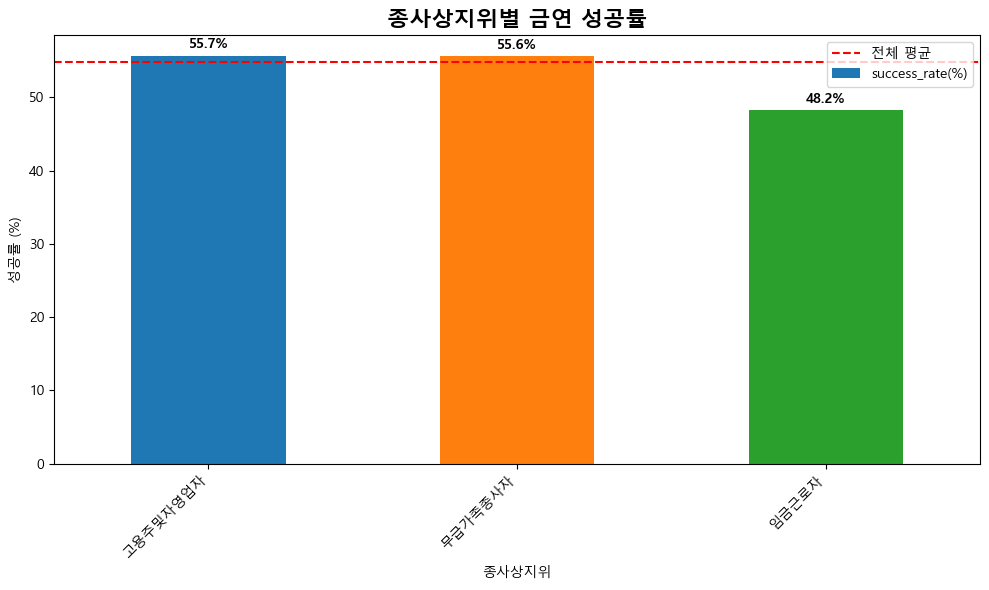

In [30]:
# 종사상지위별 금연 성공률
emp_success = df_work[df_work['soa_01z1'] == 1.0].groupby('soa_07z1_decoded')['churn'].agg(
    ['sum', 'count', 'mean']
)
emp_success['success_rate(%)'] = emp_success['mean'] * 100

print('=== 종사상지위별 금연 성공률 ===')
print(emp_success[['count', 'success_rate(%)']])

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))
emp_success['success_rate(%)'].plot(kind='bar', ax=ax, color=TEAM_COLORS['palette'])
ax.set_title('종사상지위별 금연 성공률', fontsize=16, fontweight='bold')
ax.set_ylabel('성공률 (%)')
ax.set_xlabel('종사상지위')
ax.axhline(df_work['churn'].mean() * 100, color='red', linestyle='--', label='전체 평균')
ax.legend()
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(emp_success['success_rate(%)']):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 📈 Step 6: 통계적 검정

In [31]:
# 1. 경제활동 여부 × 금연 성공
print('=== 경제활동 여부 × 금연 성공 카이제곱 검정 ===')
ct1 = pd.crosstab(df_work['soa_01z1_decoded'], df_work['churn'])
chi2_1, p_1, dof_1, _ = stats.chi2_contingency(ct1)
print(f'χ² = {chi2_1:.2f}, p-value = {p_1:.4e}')
print(f'결론: {"✅ 유의한 상관관계 있음" if p_1 < 0.05 else "❌ 유의하지 않음"}')

# 2. 직업분류 × 금연 성공
print('\n=== 직업분류 × 금연 성공 카이제곱 검정 ===')
ct2 = pd.crosstab(df_work[df_work['soa_01z1'] == 1.0]['soa_06z2_decoded'], 
                   df_work[df_work['soa_01z1'] == 1.0]['churn'])
chi2_2, p_2, dof_2, _ = stats.chi2_contingency(ct2)
print(f'χ² = {chi2_2:.2f}, p-value = {p_2:.4e}')
print(f'결론: {"✅ 유의한 상관관계 있음" if p_2 < 0.05 else "❌ 유의하지 않음"}')

# 3. 종사상지위 × 금연 성공
print('\n=== 종사상지위 × 금연 성공 카이제곱 검정 ===')
ct3 = pd.crosstab(df_work[df_work['soa_01z1'] == 1.0]['soa_07z1_decoded'], 
                   df_work[df_work['soa_01z1'] == 1.0]['churn'])
chi2_3, p_3, dof_3, _ = stats.chi2_contingency(ct3)
print(f'χ² = {chi2_3:.2f}, p-value = {p_3:.4e}')
print(f'결론: {"✅ 유의한 상관관계 있음" if p_3 < 0.05 else "❌ 유의하지 않음"}')

=== 경제활동 여부 × 금연 성공 카이제곱 검정 ===
χ² = 1374.51, p-value = 7.2517e-301
결론: ✅ 유의한 상관관계 있음

=== 직업분류 × 금연 성공 카이제곱 검정 ===
χ² = 978.75, p-value = 6.5685e-205
결론: ✅ 유의한 상관관계 있음

=== 종사상지위 × 금연 성공 카이제곱 검정 ===
χ² = 336.71, p-value = 7.6791e-74
결론: ✅ 유의한 상관관계 있음


## 💡 Step 7: 주요 발견사항 및 인사이트

### 📌 분석 결과 요약

#### 1. 경제활동 여부의 영향
- **비경제활동자**: 64.76% (24,973명)
- **경제활동자**: 51.01% (64,784명)
- **차이**: 13.75%p (비경제활동자가 현저히 높음!)
- **원인**: 스트레스 감소, 시간 여유, 고령층 건강 의식

#### 2. 직업별 특성
- **최고**: 농림어업 (62.31%), 전문가 (55.55%)
- **최저**: 군인 (39.60%), 기능원 (42.65%)
- **차이**: 22.71%p (직업 간 큰 격차)
- **패턴**: 화이트칼라 > 블루칼라

#### 3. 종사상지위의 영향
- **자영업/고용주**: 55.68%
- **무급가족종사자**: 55.58%
- **임금근로자**: 48.22% (가장 낮음)
- **차이**: 7.46%p
- **원인**: 업무 자율성, 스트레스 수준

#### 4. 통계적 유의성
- 모든 변수 **p < 0.001** (매우 유의)
- 경제활동 여부: χ² = 1,374.51
- 직업분류: χ² = 978.75
- 종사상지위: χ² = 336.71

### 💡 **모델링 시사점**

**변수 중요도**:
- ⭐⭐⭐⭐⭐ **경제활동 여부** (최우선)
- ⭐⭐⭐⭐⭐ **직업분류** (세부 그룹화)
- ⭐⭐⭐⭐ **종사상지위** (보조)

**전처리**:
- 경제활동: Binary (그대로 사용)
- 직업: 3그룹 (저/중/고위험)
- 종사상지위: Binary (임금근로 vs 기타)

**상호작용**:
- 교육수준 × 경제활동 (필수)
- 교육수준 × 직업 (권장)
- 연령 × 경제활동 (필수)

---


### ✅ 다음 단계
- [ ] 교육수준 분석 결과와 통합
- [ ] 상호작용 효과 분석 (교육 × 경제활동)
- [ ] Feature Engineering
- [ ] 모델링 준비